In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer

In [5]:
# Loading the Dirty Cafe Sales Dataset to clean it .
df = pd.read_csv('dirty_cafe_sales.csv')

In [6]:
# Analyzed the Shape of the Dataset : It has 10000 rows and 8 columns.
# Dataset is nor too big nor too small.
df.shape

(10000, 8)

In [ ]:
# First we look at the dataset and check the values to get an overall idea of the data we are working with.
df.head()


,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
0,TXN_1961373,Coffee,2,2.0,4.0,Credit Card,Takeaway,2023-09-08
1,TXN_4977031,Cake,4,3.0,12.0,Cash,In-store,2023-05-16
2,TXN_4271903,Cookie,4,1.0,ERROR,Credit Card,In-store,2023-07-19
3,TXN_7034554,Salad,2,5.0,10.0,UNKNOWN,UNKNOWN,2023-04-27
4,TXN_3160411,Coffee,2,2.0,4.0,Digital Wallet,In-store,2023-06-11


In [ ]:
# The column names are listed so we can manipualte them easily , and If there is any string formatting done on column names,
# it will be easily visible in this step.


# I did many more operations and experimentation and found out that actually there is a correlation between the columns : 
#   'Quantity', 'Price Per Unit' , 'Total Spent'
#  Basically :              Total Spent = Quantity * Price Per Unit
# This was a really helpful observation as we need this relation in further cleaning and imputation of values.
df.columns

Index(['Transaction ID', 'Item', 'Quantity', 'Price Per Unit', 'Total Spent',
       'Payment Method', 'Location', 'Transaction Date'],
      dtype='object')

In [9]:
# Here we basically look for the data type and the no of non null values for each column.
# Crucial as we must have dtype to be numbers (int,float) before applying Machine Learning Algorithms.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Transaction ID    10000 non-null  object
 1   Item              9667 non-null   object
 2   Quantity          9862 non-null   object
 3   Price Per Unit    9821 non-null   object
 4   Total Spent       9827 non-null   object
 5   Payment Method    7421 non-null   object
 6   Location          6735 non-null   object
 7   Transaction Date  9841 non-null   object
dtypes: object(8)
memory usage: 625.1+ KB


In [11]:
# Here I was was checking for the 0.05 criteria for dropping rows.
# Basically If any column has values MCAR (Missing Completelt At Random) then we can drop these rows in them if they
# have a null percentage less than or equal to 5.

# I even dropped the rows on this basis but I realised something later , which is addressed in steps.
df.isnull().mean()

Transaction ID      0.0000
Item                0.0333
Quantity            0.0138
Price Per Unit      0.0179
Total Spent         0.0173
Payment Method      0.2579
Location            0.3265
Transaction Date    0.0159
dtype: float64

In [12]:
# Similar to the above but this returns the actual count of rows missing for each column.
df.isnull().sum()

Transaction ID         0
Item                 333
Quantity             138
Price Per Unit       179
Total Spent          173
Payment Method      2579
Location            3265
Transaction Date     159
dtype: int64

In [14]:
# This is a very important information displaying function , but see there are lot of rows missing for this ,
# that must also give information of the numerica data , something is fishy as all the columns were object (string) .

# This leads to conclusion : we must find out all the values that are present in each column and understand what's going on inside .
df.describe()

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
count,10000,9667,9862,9821,9827,7421,6735,9841
unique,10000,10,7,8,19,5,4,367
top,TXN_1961373,Juice,5,3.0,6.0,Digital Wallet,Takeaway,UNKNOWN
freq,1,1171,2013,2429,979,2291,3022,159


In [ ]:
# Somewhat of a blunt step but this reveals a lot of information
'''
                Apperantely afterwards I analyzed these columns one by one and found out 
                that almost every column except date and Transaction has a value :
                'ERROR' and 'UNKNOWN' in them merged with np.nan.
'''
# Then I did a bit of research and found that these could be Systematic errors or some sort of unknown errors(Human mistake,bad getters,etc.).
for i in df.columns:
    print(df[i].unique()) 

['TXN_1961373' 'TXN_4977031' 'TXN_4271903' ... 'TXN_5255387' 'TXN_7695629'
 'TXN_6170729']
['Coffee' 'Cake' 'Cookie' 'Salad' 'Smoothie' 'UNKNOWN' 'Sandwich' nan
 'ERROR' 'Juice' 'Tea']
['2' '4' '5' '3' '1' 'ERROR' 'UNKNOWN' nan]
['2.0' '3.0' '1.0' '5.0' '4.0' '1.5' nan 'ERROR' 'UNKNOWN']
['4.0' '12.0' 'ERROR' '10.0' '20.0' '9.0' '16.0' '15.0' '25.0' '8.0' '5.0'
 '3.0' '6.0' nan 'UNKNOWN' '2.0' '1.0' '7.5' '4.5' '1.5']
['Credit Card' 'Cash' 'UNKNOWN' 'Digital Wallet' 'ERROR' nan]
['Takeaway' 'In-store' 'UNKNOWN' nan 'ERROR']
['2023-09-08' '2023-05-16' '2023-07-19' '2023-04-27' '2023-06-11'
 '2023-03-31' '2023-10-06' '2023-10-28' '2023-07-28' '2023-12-31'
 '2023-11-07' 'ERROR' '2023-05-03' '2023-06-01' '2023-03-21' '2023-11-15'
 '2023-06-10' '2023-02-24' '2023-03-25' '2023-01-15' '2023-04-04'
 '2023-03-30' '2023-12-01' '2023-09-18' '2023-06-03' '2023-12-13'
 '2023-04-20' '2023-04-10' '2023-03-11' '2023-06-02' '2023-11-06'
 '2023-08-15' '2023-10-09' '2023-05-28' '2023-07-17' '2023-04-29'


In [ ]:
# Now we will plot to see whether these values are present in less amount or flooded with it .
for i in ['Item','Payment Method','Location','Price Per Unit','Quantity']:
    plt.figure(figsize=(8,5))
    plt.subplot()
    sns.barplot(df[i],color='cyan')
    plt.tight_layout()
    plt.show()

In [787]:
df['Transaction ID'] = df['Transaction ID'].str.strip("TXN_").astype(int)

In [702]:
a = 0
for i in df.columns:
    print(f'{i} : {(df[i] == 'ERROR').sum()}')
    a += (df[i] == 'ERROR').sum()
print(f"Total ERROR found : {a}")

Transaction ID : 0
Item : 292
Quantity : 170
Price Per Unit : 190
Total Spent : 164
Payment Method : 306
Location : 358
Transaction Date : 142
Total ERROR found : 1622


In [703]:
a = 0
for i in df.columns:
    print(f'{i} : {(df[i] == 'UNKNOWN').sum()}')
    a += (df[i] == 'UNKNOWN').sum()
print(f"Total UNKNOWN found : {a}")

Transaction ID : 0
Item : 344
Quantity : 171
Price Per Unit : 164
Total Spent : 165
Payment Method : 293
Location : 338
Transaction Date : 159
Total UNKNOWN found : 1634


In [704]:
df.sample(5)

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
3957,7952916,Coffee,4,2.0,8.0,NaN,NaN,2023-12-10
7708,3454881,Salad,1,5.0,5.0,Cash,In-store,2023-11-29
1917,7907499,Juice,3,3.0,9.0,Digital Wallet,Takeaway,2023-04-18
1151,2367947,Smoothie,5,4.0,20.0,NaN,Takeaway,2023-05-13
4942,2525207,Cookie,2,1.0,2.0,Digital Wallet,NaN,2023-11-25


In [705]:
df['Price Per Unit'] = pd.to_numeric(df['Price Per Unit'],errors='coerce')
df['Quantity'] = pd.to_numeric(df['Quantity'],errors='coerce')
df['Total Spent'] = pd.to_numeric(df['Total Spent'],errors='coerce')

In [706]:
df['Price Per Unit'].dtype,df['Quantity'].dtype,df['Total Spent'].dtype

(dtype('float64'), dtype('float64'), dtype('float64'))

In [707]:
df['Price Per Unit'] = np.where(
                                    df['Price Per Unit'].isnull(),
                                    df['Total Spent']/df['Quantity'],
                                    df['Price Per Unit']
)

In [708]:
df['Price Per Unit'].isnull().sum()

np.int64(38)

In [709]:
df['Total Spent'] = np.where(
                                    df['Total Spent'].isnull(),
                                    df['Price Per Unit']*df['Quantity'],
                                    df['Total Spent']
)

In [710]:
df['Price Per Unit'].isnull().sum()

np.int64(38)

In [711]:
df['Quantity'] = np.where(
                                    df['Quantity'].isnull(),
                                    df['Total Spent']/df['Price Per Unit'],
                                    df['Quantity']
)

In [712]:
df['Quantity'].isnull().sum()

np.int64(38)

In [713]:
df['Quantity_Imputed'] = (df['Quantity'].isna()).astype(int)
df['Price Per Unit_Imputed'] = (df['Price Per Unit'].isna()).astype(int)
df['Total Spent_Imputed'] = (df['Total Spent'].isna()).astype(int)

In [714]:
df # Tier 0

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date,Quantity_Imputed,Price Per Unit_Imputed,Total Spent_Imputed
0,1961373,Coffee,2.0,2.0,4.0,Credit Card,Takeaway,2023-09-08,0,0,0
1,4977031,Cake,4.0,3.0,12.0,Cash,In-store,2023-05-16,0,0,0
2,4271903,Cookie,4.0,1.0,4.0,Credit Card,In-store,2023-07-19,0,0,0
3,7034554,Salad,2.0,5.0,10.0,UNKNOWN,UNKNOWN,2023-04-27,0,0,0
4,3160411,Coffee,2.0,2.0,4.0,Digital Wallet,In-store,2023-06-11,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,7672686,Coffee,2.0,2.0,4.0,NaN,UNKNOWN,2023-08-30,0,0,0
9996,9659401,NaN,3.0,1.0,3.0,Digital Wallet,NaN,2023-06-02,0,0,0
9997,5255387,Coffee,4.0,2.0,8.0,Digital Wallet,NaN,2023-03-02,0,0,0
9998,7695629,Cookie,3.0,1.0,3.0,Digital Wallet,NaN,2023-12-02,0,0,0


In [715]:
df['Total Spent_Imputed'].unique(),df['Quantity_Imputed'].unique(),df['Price Per Unit_Imputed'].unique()

(array([0, 1]), array([0, 1]), array([0, 1]))

In [716]:
df['Quantity'] = df['Quantity'].fillna(df['Quantity'].mode()[0])

In [717]:
df['Quantity'].isnull().sum()

np.int64(0)

In [718]:
conditions = [
    ( df['Price Per Unit_Imputed'] == 0  ),
    ( (df['Price Per Unit_Imputed'] == 1) & (df['Quantity_Imputed'] == 0)  ),
    ( (df['Price Per Unit_Imputed'] == 1) & (df['Quantity_Imputed'] == 1)  )
]
choices = [0,1,2]
df['Price Tier'] = np.select(condlist=conditions , choicelist=choices , default=0)

In [719]:
df['Price Per Unit'] = np.where(
                                    df['Price Per Unit'].isna(),
                                    df['Total Spent']/df['Quantity'],
                                    df['Price Per Unit']
)

In [720]:
df['Price Per Unit'].isnull().sum()

np.int64(20)

In [721]:
conditions = [
    ( df['Total Spent_Imputed'] == 0  ),
    ( (df['Total Spent_Imputed'] == 1) & (df['Price Per Unit_Imputed'] == 0) & (df['Quantity_Imputed'] == 1)  ),
    ( (df['Total Spent_Imputed'] == 1) & (df['Price Per Unit_Imputed'] == 1) & (df['Quantity_Imputed'] == 0)  ),
    ( (df['Total Spent_Imputed'] == 1) & (df['Price Per Unit_Imputed'] == 1) & (df['Quantity_Imputed'] == 1)  )
]
choices = [0,2,2,3]
df['Total Spent Tier'] = np.select(condlist=conditions , choicelist=choices , default=1)

In [722]:
df['Total Spent Tier'].unique()

array([0, 2])

In [723]:
df['Total Spent'] = np.where(
                                    df['Total Spent'].isnull(),
                                    df['Price Per Unit']*df['Quantity'],
                                    df['Total Spent']
)

In [724]:
df['Total Spent'].isnull().sum()

np.int64(20)

In [725]:
price_per_unit_missing = df['Price Per Unit'].isna()

In [726]:
df.loc[price_per_unit_missing,'Price Tier'] = 1 

In [727]:
df['Price Per Unit'] = df['Price Per Unit'].fillna(df['Price Per Unit'].mode()[0])

In [728]:
df['Price Per Unit'].isnull().sum()

np.int64(0)

In [729]:
conditions = [
    ( df['Total Spent_Imputed'] == 0  ),
    ( (df['Total Spent_Imputed'] == 1) & (df['Price Tier'] == 0) & (df['Quantity_Imputed'] == 1)  ),
    ( (df['Total Spent_Imputed'] == 1) & (df['Price Tier'] == 1) & (df['Quantity_Imputed'] == 0)  ),
    ( (df['Total Spent_Imputed'] == 1) & (df['Price Tier'] == 1) & (df['Quantity_Imputed'] == 1)  )
]
choices = [0,2,2,3]
df['Total Spent Tier'] = np.select(condlist=conditions , choicelist=choices , default=1)

In [730]:
df['Total Spent'] = np.where(
                                    df['Total Spent'].isnull(),
                                    df['Price Per Unit']*df['Quantity'],
                                    df['Total Spent']
)

In [731]:
df['Total Spent'].isna().sum()

np.int64(0)

In [732]:
df['Total Spent Tier'].unique()

array([0, 2])

In [744]:
df.isna().sum()

Transaction ID               0
Item                       333
Quantity                     0
Price Per Unit               0
Total Spent                  0
Payment Method               0
Location                  3265
Transaction Date           159
Quantity_Imputed             0
Price Per Unit_Imputed       0
Total Spent_Imputed          0
Price Tier                   0
Total Spent Tier             0
Quantity_Tier                0
Payment Method_Missing       0
dtype: int64

In [734]:
df['Quantity_Tier'] = df['Quantity_Imputed']

In [735]:
df

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date,Quantity_Imputed,Price Per Unit_Imputed,Total Spent_Imputed,Price Tier,Total Spent Tier,Quantity_Tier
0,1961373,Coffee,2.0,2.0,4.0,Credit Card,Takeaway,2023-09-08,0,0,0,0,0,0
1,4977031,Cake,4.0,3.0,12.0,Cash,In-store,2023-05-16,0,0,0,0,0,0
2,4271903,Cookie,4.0,1.0,4.0,Credit Card,In-store,2023-07-19,0,0,0,0,0,0
3,7034554,Salad,2.0,5.0,10.0,UNKNOWN,UNKNOWN,2023-04-27,0,0,0,0,0,0
4,3160411,Coffee,2.0,2.0,4.0,Digital Wallet,In-store,2023-06-11,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,7672686,Coffee,2.0,2.0,4.0,NaN,UNKNOWN,2023-08-30,0,0,0,0,0,0
9996,9659401,NaN,3.0,1.0,3.0,Digital Wallet,NaN,2023-06-02,0,0,0,0,0,0
9997,5255387,Coffee,4.0,2.0,8.0,Digital Wallet,NaN,2023-03-02,0,0,0,0,0,0
9998,7695629,Cookie,3.0,1.0,3.0,Digital Wallet,NaN,2023-12-02,0,0,0,0,0,0


In [740]:
df['Payment Method'].unique()

array(['Credit Card', 'Cash', nan, 'Digital Wallet'], dtype=object)

In [738]:
df['Payment Method'].replace(['UNKNOWN','ERROR',''],np.nan,inplace=True)

C:\Users\hp\AppData\Local\Temp\ipykernel_10016\80247040.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Payment Method'].replace(['UNKNOWN','ERROR',''],np.nan,inplace=True)


In [741]:
df['Payment Method_Missing'] = df['Payment Method'].isna().astype(int)

In [743]:
df['Payment Method'].fillna('Missing',inplace=True)

In [745]:
df

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date,Quantity_Imputed,Price Per Unit_Imputed,Total Spent_Imputed,Price Tier,Total Spent Tier,Quantity_Tier,Payment Method_Missing
0,1961373,Coffee,2.0,2.0,4.0,Credit Card,Takeaway,2023-09-08,0,0,0,0,0,0,0
1,4977031,Cake,4.0,3.0,12.0,Cash,In-store,2023-05-16,0,0,0,0,0,0,0
2,4271903,Cookie,4.0,1.0,4.0,Credit Card,In-store,2023-07-19,0,0,0,0,0,0,0
3,7034554,Salad,2.0,5.0,10.0,Missing,UNKNOWN,2023-04-27,0,0,0,0,0,0,1
4,3160411,Coffee,2.0,2.0,4.0,Digital Wallet,In-store,2023-06-11,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,7672686,Coffee,2.0,2.0,4.0,Missing,UNKNOWN,2023-08-30,0,0,0,0,0,0,1
9996,9659401,NaN,3.0,1.0,3.0,Digital Wallet,NaN,2023-06-02,0,0,0,0,0,0,0
9997,5255387,Coffee,4.0,2.0,8.0,Digital Wallet,NaN,2023-03-02,0,0,0,0,0,0,0
9998,7695629,Cookie,3.0,1.0,3.0,Digital Wallet,NaN,2023-12-02,0,0,0,0,0,0,0


In [749]:
df.Location.unique()

array(['Takeaway', 'In-store', nan], dtype=object)

In [747]:
df['Location'].replace(['UNKNOWN','ERROR',''],np.nan,inplace=True)

In [750]:
df['Location'].isna().sum()

np.int64(3961)

In [763]:
loc_map_forward = {
                'Takeaway' : 0,
                'In-store'  : 1,
}

loc_map_backward = {
                0 : 'Takeaway' ,
                1 : 'In-store'
}

impute_columns = ['Quantity', 'Price Per Unit', 'Total Spent', 'Location_encoded']

In [760]:
df['Location_encoded'] = df['Location'].map(loc_map_forward)

In [764]:
knn = KNNImputer(n_neighbors=5)

In [765]:
df[impute_columns] = knn.fit_transform(df[impute_columns])

In [767]:
df['Location_encoded'] = df['Location_encoded'].round().astype(int)

In [769]:
df['Location'] = df['Location_encoded'].map(loc_map_backward)

In [784]:
df.isnull().sum()

Transaction ID            0
Item                      0
Quantity                  0
Price Per Unit            0
Total Spent               0
Payment Method            0
Location                  0
Transaction Date          0
Quantity_Imputed          0
Price Per Unit_Imputed    0
Total Spent_Imputed       0
Price Tier                0
Total Spent Tier          0
Quantity_Tier             0
Payment Method_Missing    0
Location_encoded          0
Item_Was_Missing          0
Date_Was_Missing          0
dtype: int64

In [773]:
df['Item_Was_Missing'] = df['Item'].isna().astype(int)

In [775]:
df['Item'] = df['Item'].fillna(
    df.groupby('Price Per Unit')['Item'].transform(
        lambda x: x.mode()[0] if not x.mode().empty else "UNKNOWN"
    )
)

In [779]:
df['Transaction Date'] = pd.to_datetime(df['Transaction Date'], errors='coerce')

In [782]:
df['Date_Was_Missing'] = df['Transaction Date'].isna().astype(int)

In [783]:
df['Transaction Date'] = df['Transaction Date'].ffill()

In [788]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Transaction ID          10000 non-null  int64         
 1   Item                    10000 non-null  object        
 2   Quantity                10000 non-null  float64       
 3   Price Per Unit          10000 non-null  float64       
 4   Total Spent             10000 non-null  float64       
 5   Payment Method          10000 non-null  object        
 6   Location                10000 non-null  object        
 7   Transaction Date        10000 non-null  datetime64[ns]
 8   Quantity_Imputed        10000 non-null  int64         
 9   Price Per Unit_Imputed  10000 non-null  int64         
 10  Total Spent_Imputed     10000 non-null  int64         
 11  Price Tier              10000 non-null  int64         
 12  Total Spent Tier        10000 non-null  int64  

In [793]:
df1 = df[:]

In [794]:
df1.columns

Index(['Transaction ID', 'Item', 'Quantity', 'Price Per Unit', 'Total Spent',
       'Payment Method', 'Location', 'Transaction Date', 'Quantity_Imputed',
       'Price Per Unit_Imputed', 'Total Spent_Imputed', 'Price Tier',
       'Total Spent Tier', 'Quantity_Tier', 'Payment Method_Missing',
       'Location_encoded', 'Item_Was_Missing', 'Date_Was_Missing'],
      dtype='object')

In [795]:
df1.drop(   columns=[ 'Price Tier','Total Spent Tier', 'Quantity_Tier'] , inplace=True)

C:\Users\hp\AppData\Local\Temp\ipykernel_10016\3711274564.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.drop(   columns=[ 'Price Tier','Total Spent Tier', 'Quantity_Tier'] , inplace=True)


In [796]:
df1

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date,Quantity_Imputed,Price Per Unit_Imputed,Total Spent_Imputed,Payment Method_Missing,Location_encoded,Item_Was_Missing,Date_Was_Missing
0,1961373,Coffee,2.0,2.0,4.0,Credit Card,Takeaway,2023-09-08,0,0,0,0,0,0,0
1,4977031,Cake,4.0,3.0,12.0,Cash,In-store,2023-05-16,0,0,0,0,1,0,0
2,4271903,Cookie,4.0,1.0,4.0,Credit Card,In-store,2023-07-19,0,0,0,0,1,0,0
3,7034554,Salad,2.0,5.0,10.0,Missing,In-store,2023-04-27,0,0,0,1,1,0,0
4,3160411,Coffee,2.0,2.0,4.0,Digital Wallet,In-store,2023-06-11,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,7672686,Coffee,2.0,2.0,4.0,Missing,Takeaway,2023-08-30,0,0,0,1,0,0,0
9996,9659401,Cookie,3.0,1.0,3.0,Digital Wallet,Takeaway,2023-06-02,0,0,0,0,0,1,0
9997,5255387,Coffee,4.0,2.0,8.0,Digital Wallet,Takeaway,2023-03-02,0,0,0,0,0,0,0
9998,7695629,Cookie,3.0,1.0,3.0,Digital Wallet,Takeaway,2023-12-02,0,0,0,0,0,0,0


<Axes: ylabel='Total Spent'>

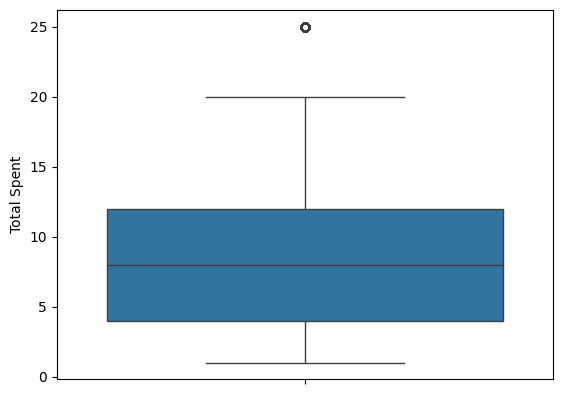

In [805]:
sns.boxplot(df1['Total Spent'])

<Axes: xlabel='count', ylabel='Payment Method'>

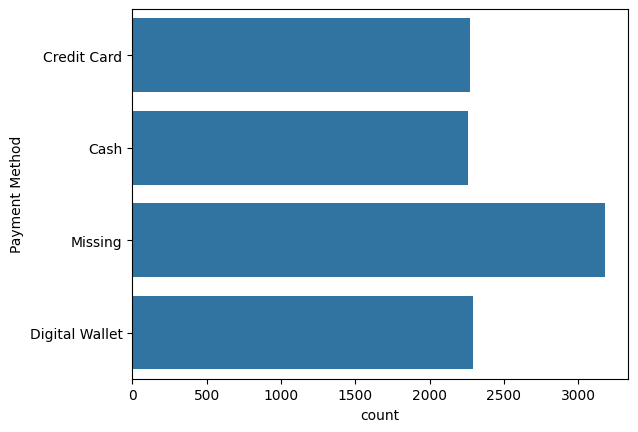

In [806]:
sns.countplot(df1['Payment Method'])

<Axes: ylabel='Transaction Date'>

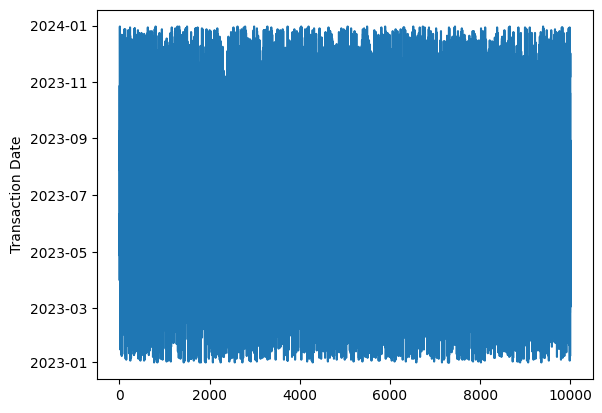

In [807]:
sns.lineplot(df1['Transaction Date'])

In [808]:
df1.to_csv('cafe_sales_cleaned.csv')